In [6]:
import numpy as np
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from skimage.transform import resize, rescale
import wrangle_data as wd

Load cell type labels and channel labels

In [7]:
conf = yaml.safe_load(Path("keren/meta.yaml").read_text())
meta_cell_types = conf["cell_types"]
meta_channels = conf["channels"]

If not done previously: load the files

In [2]:
X, y, cell_types = wd.load_files([4, 5, 6, 7, 8])

Normalize the data

In [4]:
X = wd.normalize(X)

In [7]:
total_cells = 0
for i in range(X.shape[0]):
    total_cells += int(np.max(y[i,:,:,0]))
total_cells

26244

Save the files up to now so that we can apply it to both Dataset1 and Dataset 2 without normalizing again

In [ ]:
np.savez("X.npz",X)
np.savez("y.npz",y)
np.savez("cell_types.npz",cell_types)

The average size of cells was previously determined to be about 500. Resizing all cell data to this size for the training set to reflect this. (I decided to round up so that data is upsized more often than downsized, to retain as much info as possible)

### Dataset 1

Get the cropped views

In [6]:
training_set, training_label = wd.cropped_views(X, y, total_cells, cell_types)

Look at the distribution of cells:

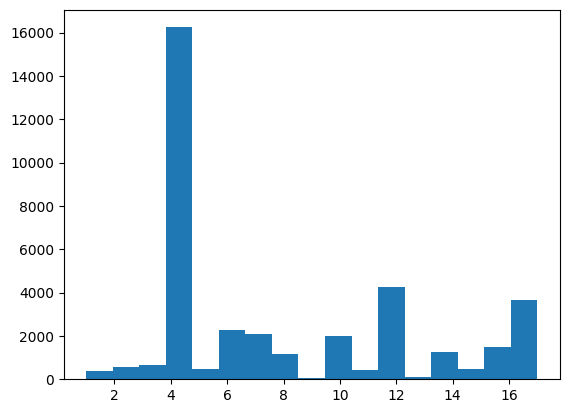

In [7]:
plt.hist(training_label_limit4, bins = 17);
plt.xticks(range(18));

### Dataset 2

(Running in new kernel so that kernel doesn't crash)

In [8]:
X = np.load(f"X.npz", allow_pickle = True)['arr_0']
y = np.load(f"y.npz", allow_pickle = True)['arr_0']
cell_types = np.load(f"cell_types.npz", allow_pickle = True)['arr_0']

From the histogram in dataset 1, cell type 4 is clearly much more abundant than the others. In order to avoid skewing our results, we will leave only 3000/16000 cells of type 4. (Additionally, from the training results of dataset 1, I realized that we should also remove failed_harmonization cells and background cells from the training set and edited the script to remove this data)

In [9]:
total_cells = 26244 # from above

In [10]:
for i in range(len(cell_types)):
    to_Array = np.array(list(cell_types[i].item().values()))
    total_cells -= len(np.where(to_Array==4)[0]) +len(np.where(to_Array==0)[0]) + len(np.where(to_Array==17)[0])
total_cells += 3000

In [9]:
import importlib as imp

In [49]:
imp.reload(wd)

<module 'wrangle_data' from '/home/iris0/Set1/wrangle_data.py'>

In [11]:
training_set, training_label = wd.cropped_views(X, y, total_cells, cell_types,exclude_type = 4, maximum = 3000)

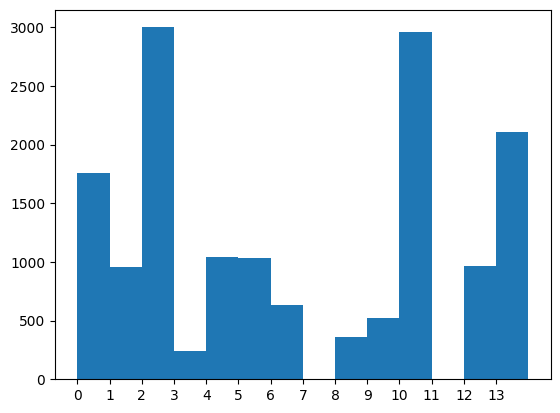

In [20]:
plt.hist(training_label[0:18324], bins = 14)
plt.xticks(np.arange(14));

Though there is still some variation, this is much more evenly distributed data and cell 4 is no longer the major type..

## After each dataset:

In [13]:
# iterate over all the cell types, get average expression of marker for each cell type
cell_type_Expression = np.zeros((int(np.max(training_label)), 51))
for ctype in range(int(np.max(training_label))):
    cell_type_Expression[ctype-1] = np.mean(np.mean(training_set[np.where(training_label==ctype),:], axis = 2), axis = 1)

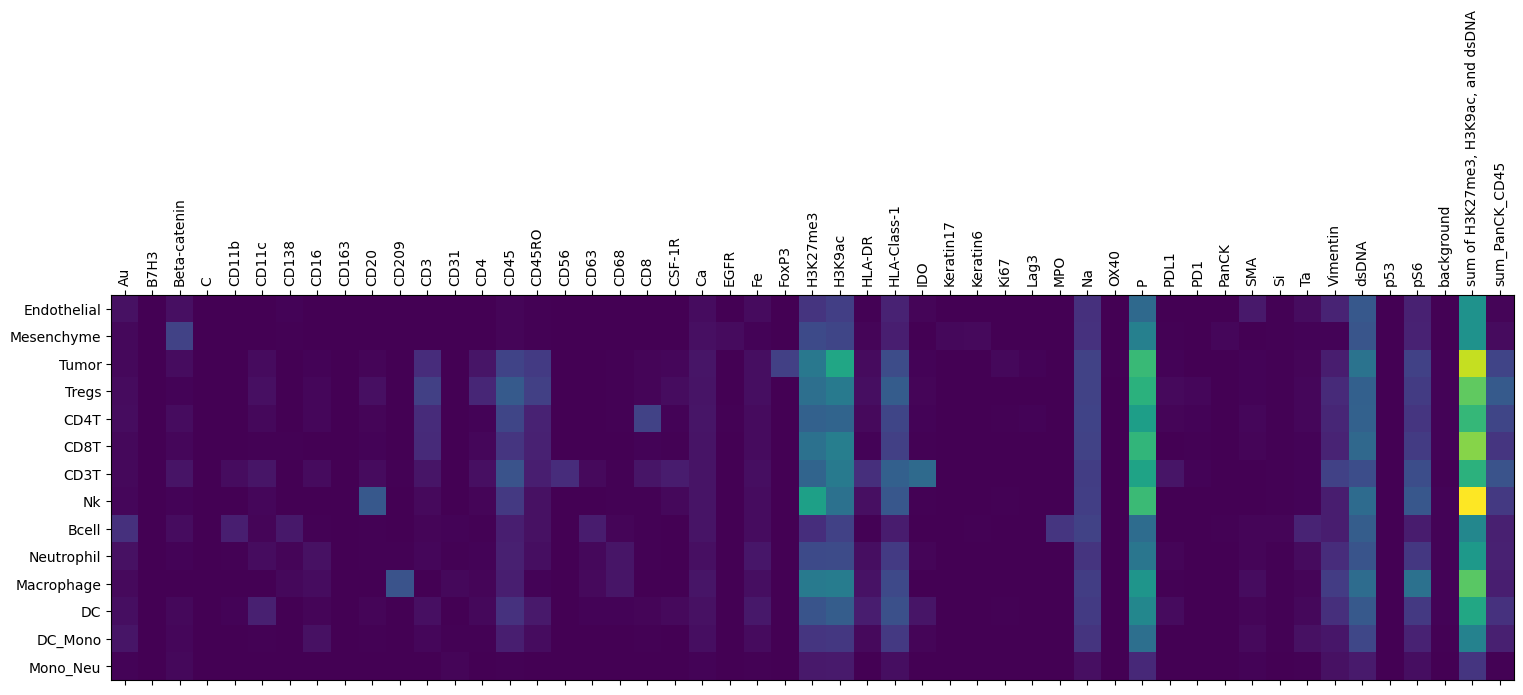

In [14]:
meta_cell_types_list = list(meta_cell_types.values())
wd.expression_panel(cell_type_Expression, meta_cell_types_list[2:], meta_channels)

I will use data from any column that shows some major variation

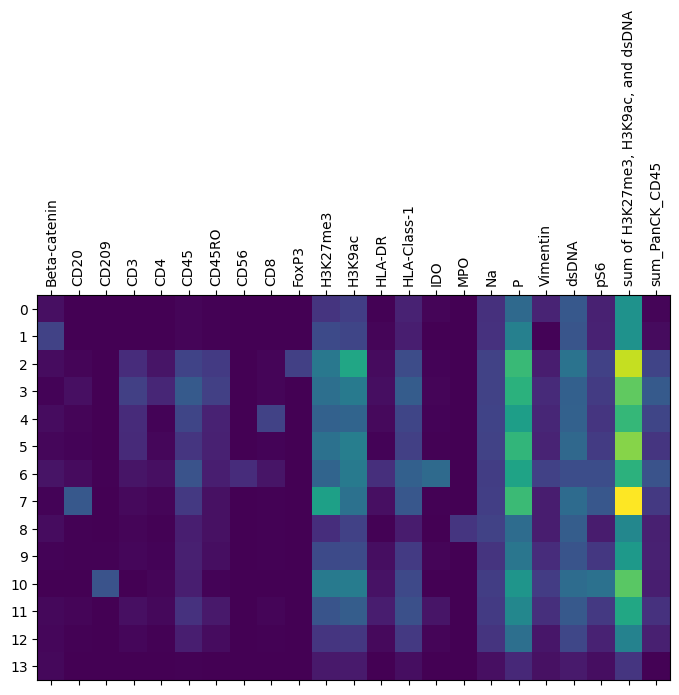

In [15]:
data_of_interest = [2, 9,10,11,13,14,15,16,19,24,25,26,27,28,29,34,35,37,44,45,47,49,50]
channels_of_interest = [meta_channels[channel] for channel in data_of_interest]
wd.expression_panel(cell_type_Expression[:, data_of_interest], meta_cell_types, channels_of_interest)

Only saving data from this subset

In [16]:
training_set_interest = training_set[...,data_of_interest]

One-hot encoding the labels for learning:

In [17]:
training_label1 = [[label] for label in training_label]

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
label_one_hot = mlb.fit_transform(training_label1)

Saving the training set

In [19]:
np.savez("training_set.npz", x=training_set_interest)
np.savez("training_set_labels.npz", y=label_one_hot)